# Equivalent Circuit Modeling of EDT Schottky Junction # 

This notebook summarizes my attempt to fit the $\frac{G}{\omega}$ data to the equivalent circuit I derived in my lab notebook. 



In [1]:
def savitzky_golay(y, window_size, order, deriv=0, rate=1):
    r"""Smooth (and optionally differentiate) data with a Savitzky-Golay filter.
    The Savitzky-Golay filter removes high frequency noise from data.
    It has the advantage of preserving the original shape and
    features of the signal better than other types of filtering
    approaches, such as moving averages techniques.
    Parameters
    ----------
    y : array_like, shape (N,)
        the values of the time history of the signal.
    window_size : int
        the length of the window. Must be an odd integer number.
    order : int
        the order of the polynomial used in the filtering.
        Must be less then `window_size` - 1.
    deriv: int
        the order of the derivative to compute (default = 0 means only smoothing)
    Returns
    -------
    ys : ndarray, shape (N)
        the smoothed signal (or it's n-th derivative).
    Notes
    -----
    The Savitzky-Golay is a type of low-pass filter, particularly
    suited for smoothing noisy data. The main idea behind this
    approach is to make for each point a least-square fit with a
    polynomial of high order over a odd-sized window centered at
    the point.
    Examples
    --------
    t = np.linspace(-4, 4, 500)
    y = np.exp( -t**2 ) + np.random.normal(0, 0.05, t.shape)
    ysg = savitzky_golay(y, window_size=31, order=4)
    import matplotlib.pyplot as plt
    plt.plot(t, y, label='Noisy signal')
    plt.plot(t, np.exp(-t**2), 'k', lw=1.5, label='Original signal')
    plt.plot(t, ysg, 'r', label='Filtered signal')
    plt.legend()
    plt.show()
    References
    ----------
    .. [1] A. Savitzky, M. J. E. Golay, Smoothing and Differentiation of
       Data by Simplified Least Squares Procedures. Analytical
       Chemistry, 1964, 36 (8), pp 1627-1639.
    .. [2] Numerical Recipes 3rd Edition: The Art of Scientific Computing
       W.H. Press, S.A. Teukolsky, W.T. Vetterling, B.P. Flannery
       Cambridge University Press ISBN-13: 9780521880688
    """
    import numpy as np
    from math import factorial
    
    try:
        window_size = np.abs(np.int(window_size))
        order = np.abs(np.int(order))
    except ValueError:
        raise ValueError("window_size and order have to be of type int")
    if window_size % 2 != 1 or window_size < 1:
        raise TypeError("window_size size must be a positive odd number")
    if window_size < order + 2:
        raise TypeError("window_size is too small for the polynomials order")
    order_range = range(order+1)
    half_window = (window_size -1) // 2
    # precompute coefficients
    b = np.mat([[k**i for i in order_range] for k in range(-half_window, half_window+1)])
    m = np.linalg.pinv(b).A[deriv] * rate**deriv * factorial(deriv)
    # pad the signal at the extremes with
    # values taken from the signal itself
    firstvals = y[0] - np.abs( y[1:half_window+1][::-1] - y[0] )
    lastvals = y[-1] + np.abs(y[-half_window-1:-1][::-1] - y[-1])
    y = np.concatenate((firstvals, y, lastvals))
    return np.convolve( m[::-1], y, mode='valid')

In [2]:
import numpy as np
import lmfit as lmf
import matplotlib.pyplot as plt
from matplotlib.pyplot import cm 
import os
import matplotlib as mpl
%matplotlib inline

#to make fonts from plots look normal
mpl.rcParams['mathtext.fontset'] = 'custom'
mpl.rcParams['mathtext.rm'] = 'Calibri'
mpl.rcParams['mathtext.it'] = 'Calibri:italic'
mpl.rcParams['mathtext.bf'] = 'Calibri:bold'

font = {'family' : 'Calibri',
        'weight' : 'normal',
        'size'   : 36}
        #'sans-serif' : 'Arial Unicode MS'}
mpl.rc('font', **font)
plt.rc('font', size=36)          # controls default text sizes

#mpl.rcParams.update({'figure.autolayout': True})
mpl.rcParams['xtick.major.size'] = 10
mpl.rcParams['xtick.major.width'] = 1.5
mpl.rcParams['xtick.minor.size'] = 4
mpl.rcParams['xtick.minor.width'] = 1.5
mpl.rcParams['ytick.major.size'] = 10
mpl.rcParams['ytick.major.width'] = 1.5
mpl.rcParams['ytick.minor.size'] = 4
mpl.rcParams['ytick.minor.width'] = 1.5
mpl.rcParams['axes.linewidth'] = 1.5 #set the value globally
mpl.rcParams['lines.markersize'] = 16
mpl.rcParams['lines.linewidth'] = 4
mpl.rcParams['xtick.direction'] = 'in'
mpl.rcParams['ytick.direction'] = 'in'
#mpl.rcParams['xtick.top'] = False
#mpl.rcParams['ytick.right'] = False




os.chdir(r'C:\Users\Eric\Desktop\Lab_Work\admittance\ligand_and_interface\analysis_work\EDT_schottky\09_2017_m1\data\data')

# os.listdir()
tmax = 8
T = np.linspace(220,220+(10*tmax),tmax,endpoint=False)
devNum = 2
voltage1 = 0

nPoints = 200
master0mv = np.zeros((tmax,nPoints,5))

gOmega = np.zeros((tmax,nPoints,5))

# the tmp data has the following format:
#      index 0 is frequency in rad/s
#      index 1 is capacitance, C
#      index 2 is susceptance, B
#      index 3 is dissipation, D
#      index 4 is conductance, G

# we create arrays to hold the G/w data with the following format:
#      index 0 is frequency in rad/s
#      index 1 is G/w(w) in Ss^(-1)
#      index 2 is Re(Z) in kOhmcm^{-2}
#      index 3 is Im(Z) in kOhmcm^{-2}
#      index 4 is |Z| in kOhmcm^{-2}



for t in range(0,tmax):
    file1 = 'dev' + str(devNum) + '_T' + np.array2string(T[t].astype(int)) +'K_Vbias' + str(voltage1) + 'mV_All_Modified.txt'     
    tmp1 = np.genfromtxt(file1)
    master0mv[t,:,0] = tmp1[2:,0]
    master0mv[t,:,1] = savitzky_golay(tmp1[2:,1],51,5)
    master0mv[t,:,2] = savitzky_golay(tmp1[2:,2],51,5)
    master0mv[t,:,3] = savitzky_golay(tmp1[2:,3],51,5)
    master0mv[t,:,4] = savitzky_golay(tmp1[2:,4],51,5)

    gOmega[t,:,0] = master0mv[t,:,0]
    gOmega[t,:,1] = (master0mv[t,:,4]/master0mv[t,:,0])
    gOmega[t,:,2] = ((master0mv[t,:,4]/((master0mv[t,:,4]**2) + (master0mv[t,:,2]**2)))*4e-2)/1e3
    gOmega[t,:,3] = ((-master0mv[t,:,2]/((master0mv[t,:,4]**2) + (master0mv[t,:,2]**2)))*4e-2)/1e3
    gOmega[t,:,4] = np.sqrt((gOmega[t,:,2]**2) + (gOmega[t,:,3]**2))
 
    
# define some simple functions to make the analysis code a bit more concise
def Gw(T):
    return gOmega[T,:,1]

def w(T):
    return master0mv[t,:,0]

def Zmag(T):
    return gOmega[T,:,4]

# input useful constants
kB = 8.617e-5

# make colormap corresponding to full dat set
colSet_tot = (cm.jet(np.linspace(0,1,11)))

# colormap offsets to correctly color the data
cOff1 = 3
cOff2 = 11

# make colormap corresponding to temeperature range we want to fit
colSet = colSet_tot[cOff1:cOff2]

# indicate the figures directory
figDir = r'C:\Users\Eric\Desktop\Lab_Work\admittance\ligand_and_interface\analysis_work\EDT_schottky\manuscript_figs\si_figs\conductance'

# indicate offset, if any. tmin = 0 indicates no offset. otherwise, input another minumum temp to start analysis
tmin = 0

In [3]:
print(T)

[ 220.  230.  240.  250.  260.  270.  280.  290.]


Plot the data to make sure we did this right.

C:\Program Files\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1288: UserWarning: findfont: Font family ['cursive'] not found. Falling back to Bitstream Vera Sans
  (prop.get_family(), self.defaultFamily[fontext]))


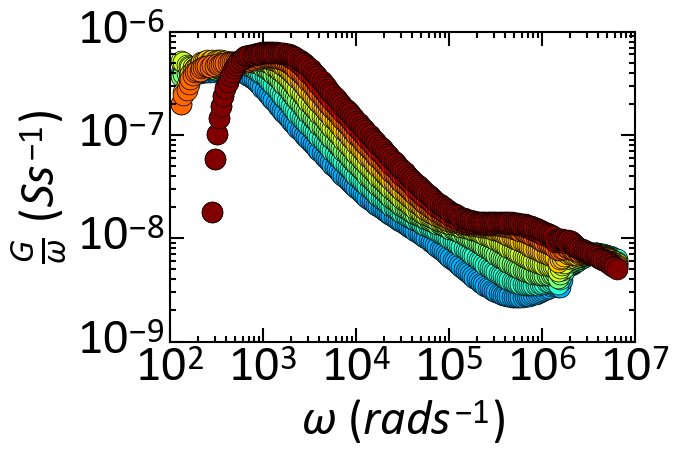

In [4]:
# G/omega plot
fig,ax = plt.subplots(1,1)
for t,c in zip(range(0,tmax),colSet):
    ax.plot(w(t),Gw(t),'o',c = c, markersize = 15)
ax.set_xlabel("$\\omega$ ($rad s^{-1}$)")
ax.set_ylabel("$\\frac{G}{\omega}$ ($Ss^{-1}$)")
ax.set_xscale("log") 
ax.set_yscale("log")
# figName = '\\G-omega_all_extended.png'
# plt.savefig(figDir + figName,dpi = 300,bbox_inches = 'tight')



Ok so far so good. Now let's try our fitting function for the test temperature Tt.

In [4]:
# define a function for the G/w response of a single RC branch
def branch(w,Ct,tau_t):
    return (w*Ct*tau_t)/(1+((w**2)*(tau_t**2)))

def branch_log(w,Ct,tau_t):
    return np.log((w*Ct*tau_t)/(1+((w**2)*(tau_t**2))))

from lmfit import Model


0.00113682102209 3.8727599603e-06


C:\Program Files\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1288: UserWarning: findfont: Font family ['cursive'] not found. Falling back to Bitstream Vera Sans
  (prop.get_family(), self.defaultFamily[fontext]))


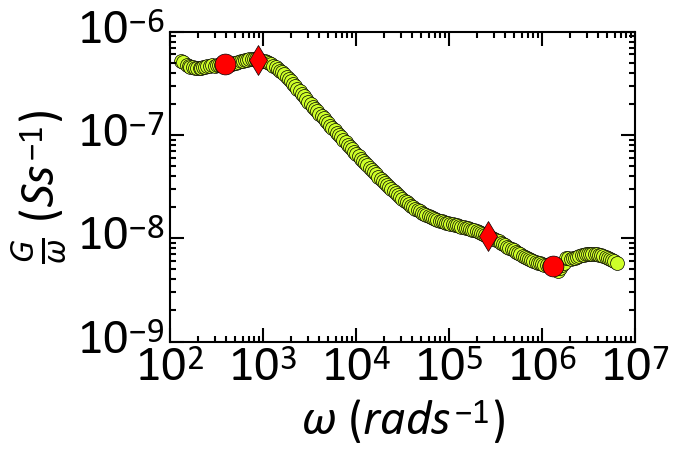

In [5]:
# define a test temperature
Tt = 3
# G/omega plot
fig,ax = plt.subplots(1,1)
ax.plot(w(Tt),Gw(Tt),'o',c = tuple(colSet[Tt]), markersize = 10)
ax.plot(w(Tt)[20],Gw(Tt)[20],'o',c='r', markersize = 15)
ax.plot(w(Tt)[170],Gw(Tt)[170],'o',c='r', markersize = 15)


ax.plot(w(Tt)[35],Gw(Tt)[35],'d',c='r', markersize = 15)
ax.plot(w(Tt)[140],Gw(Tt)[140],'d',c='r', markersize = 15)

ax.set_xlabel("$\\omega$ ($rad s^{-1}$)")
ax.set_ylabel("$\\frac{G}{\omega}$ ($Ss^{-1}$)")
ax.set_xscale("log") 
ax.set_yscale("log")
# figName = '\\nyquist_400mV_all.png'
# plt.savefig(figDir + figName,dpi = 300)

# set frequency bounds to help fit
bound1 = 20
bound2= 170

# set \tau guesses
tau1 = 1/w(Tt)[35]
tau2 = 1/w(Tt)[140]

print(tau1,tau2)



[[Model]]
    (Model(branch, prefix='t1_') + Model(branch, prefix='t2_'))
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 13
    # data points      = 150
    # variables        = 4
    chi-square         = 3.2401e-08
    reduced chi-square = 2.2193e-10
    Akaike info crit   = -3330.35576
    Bayesian info crit = -3318.31322
[[Variables]]
    t1_Ct:     1.0984e-06 +/- 9.1531e-09 (0.83%) (init = 2e-06)
    t1_tau_t:  0.00152338 +/- 1.9971e-05 (1.31%) (init = 0.001136821)
    t2_Ct:     1.6504e-08 +/- 5.3276e-10 (3.23%) (init = 1.4e-08)
    t2_tau_t:  3.7076e-06 +/- 1.9686e-07 (5.31%) (init = 3.87276e-06)
[[Correlations]] (unreported correlations are < 0.100)
    C(t1_Ct, t1_tau_t) =  0.843
    C(t2_Ct, t2_tau_t) =  0.681
    C(t1_tau_t, t2_Ct) =  0.113



C:\Program Files\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1288: UserWarning: findfont: Font family ['cursive'] not found. Falling back to Bitstream Vera Sans
  (prop.get_family(), self.defaultFamily[fontext]))


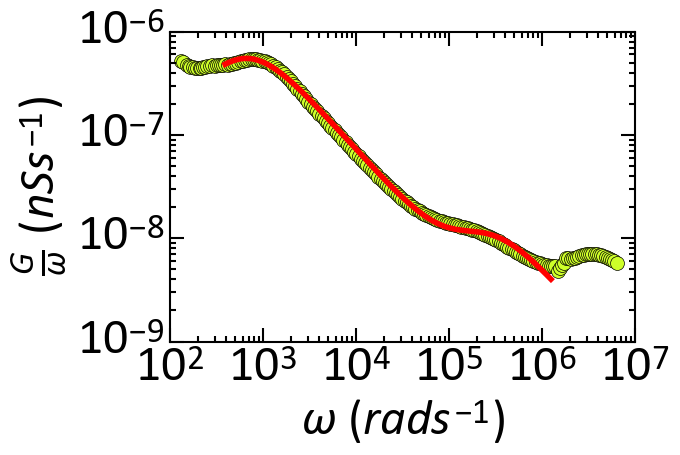

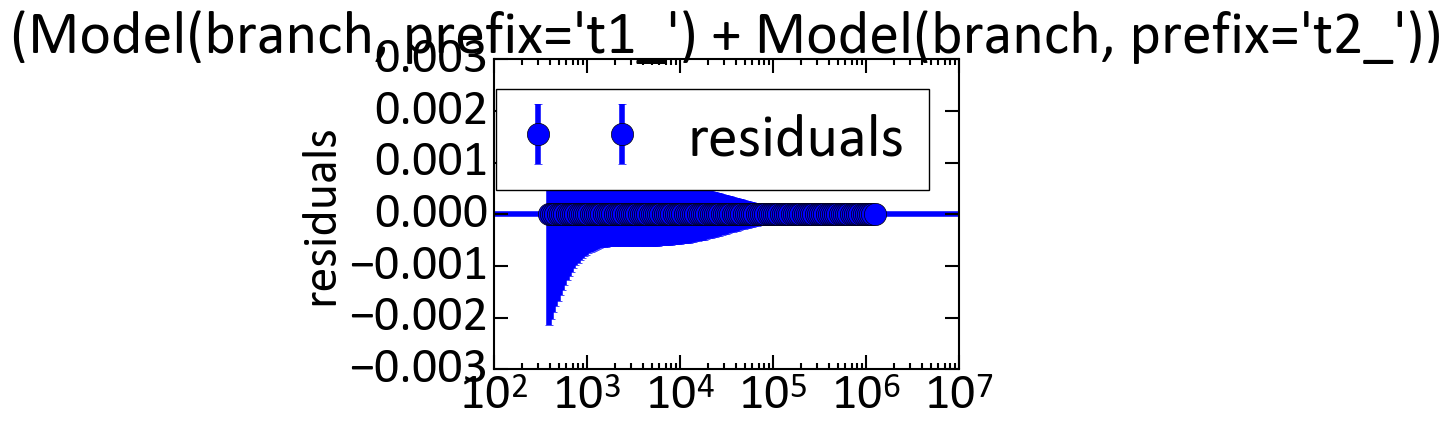

In [6]:
# define and run an aggregate conductance model

# define the name for each of the models. note that prefix 't1' is for interface states, 't2' is for deep traps
branch1 = Model(branch,prefix = 't1_')
branch2 = Model(branch,prefix = 't2_')

# define the aggregate moel
gModel = branch1 + branch2

# add parameters with guesses
params = lmf.Parameters()  

params.add('t1_Ct',value = 5e-6, min = 1e-8, max = 2e-6)
# params.add('t1_tau_t',value = tau1, vary = False, min = 0, max = 1e-1)
params.add('t1_tau_t',value = tau1, min = 0, max = 1e-2)

params.add('t2_Ct',value = 1.4e-8, min = 0, max = 1e-7)
# params.add('t2_tau_t',value = tau2,vary = False, min = 0, max = 1e-3)
params.add('t2_tau_t',value = tau2, min = 0, max = 1e-5)

# ensure data is run over proper range
data = (Gw(Tt)[bound1:bound2])
weights = 1/(.01*Zmag(Tt)[bound1:bound2])

#try the fit
fit_result = gModel.fit(data, w = w(Tt)[bound1:bound2],params = params,weights = weights)
print(fit_result.fit_report())

# G/w with fit
fig,ax = plt.subplots(1,1)
ax.plot(w(Tt),Gw(Tt),'o',c = tuple(colSet[Tt]), markersize = 10)
ax.plot(w(Tt)[bound1:bound2],fit_result.best_fit,color = 'r')
ax.set_xlabel("$\\omega$ ($rad s^{-1}$)")
ax.set_ylabel("$\\frac{G}{\omega}$ ($nSs^{-1}$)")
ax.set_xscale("log") 
ax.set_yscale("log")


fig,ax = plt.subplots(1,1)
fit_result.plot_residuals(ax=ax)
ax.set_xscale('log')
# ax.set_xlim([5e2,1e4])
# ax.set_ylim([-1e4,1e4])


In [7]:
print(fit_result.params['t1_tau_t'].value*2*np.pi)

print(0.0131*fit_result.params['t1_tau_t'].value*2*np.pi)

print(9.6e-3/1.09e-6)
print(2.31e-5/1.65e-8)

0.00957169827735
0.000125389247433
8807.339449541285
1400.0


[ 0.00174896  0.00148743  0.00113682  0.00113682  0.00077637  0.00066039
  0.00056239  0.00050365]
[  1.14261572e-05   8.71843017e-06   6.65224425e-06   3.87275996e-06
   2.95491994e-06   2.25460672e-06   1.72025923e-06   1.46253888e-06]


C:\Program Files\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1288: UserWarning: findfont: Font family ['cursive'] not found. Falling back to Bitstream Vera Sans
  (prop.get_family(), self.defaultFamily[fontext]))


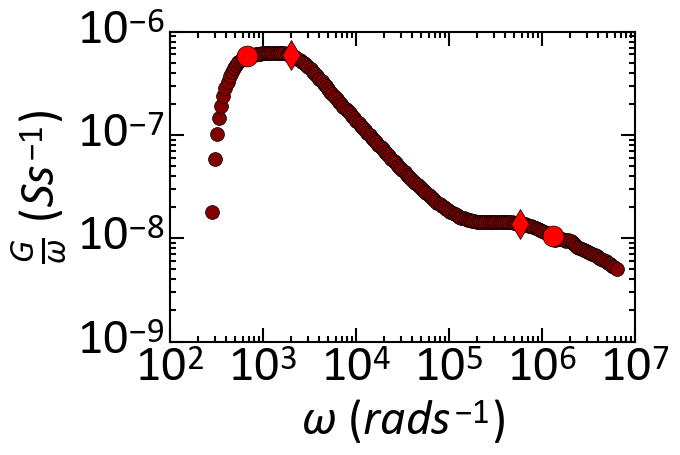

In [8]:
# input fit parameters for all temperatures

# define a test temperature
Tt = 7
# G/omega plot
fig,ax = plt.subplots(1,1)
ax.plot(w(Tt),Gw(Tt),'o',c = tuple(colSet[Tt]), markersize = 10)
ax.plot(w(Tt)[30],Gw(Tt)[30],'o',c='r', markersize = 15)
ax.plot(w(Tt)[170],Gw(Tt)[170],'o',c='r', markersize = 15)


ax.plot(w(Tt)[50],Gw(Tt)[50],'d',c='r', markersize = 15)
ax.plot(w(Tt)[155],Gw(Tt)[155],'d',c='r', markersize = 15)

ax.set_xlabel("$\\omega$ ($rad s^{-1}$)")
ax.set_ylabel("$\\frac{G}{\omega}$ ($Ss^{-1}$)")
ax.set_xscale("log") 
ax.set_yscale("log")
# figName = '\\nyquist_400mV_all.png'
# plt.savefig(figDir + figName,dpi = 300)

bound1 = np.zeros(tmax)
tau1 = np.zeros(tmax)

bound2 = np.zeros(tmax)
tau2 = np.zeros(tmax)

bound1[0] = 5
bound1[1] = 15
bound1[2] = 18
bound1[3] = 20
bound1[4] = 20
bound1[5] = 20
bound1[6] = 30
bound1[7] = 30

bound2[0] = 150
bound2[1] = 150
bound2[2] = 163
bound2[3] = 170
bound2[4] = 170
bound2[5] = 170
bound2[6] = 170
bound2[7] = 170

tau1[0] = 1/w(Tt)[27]
tau1[1] = 1/w(Tt)[30]
tau1[2] = 1/w(Tt)[35]
tau1[3] = 1/w(Tt)[35]
tau1[4] = 1/w(Tt)[42]
tau1[5] = 1/w(Tt)[45]
tau1[6] = 1/w(Tt)[48]
tau1[7] = 1/w(Tt)[50]

tau2[0] = 1/w(Tt)[120]
tau2[1] = 1/w(Tt)[125]
tau2[2] = 1/w(Tt)[130]
tau2[3] = 1/w(Tt)[140]
tau2[4] = 1/w(Tt)[145]
tau2[5] = 1/w(Tt)[150]
tau2[6] = 1/w(Tt)[155]
tau2[7] = 1/w(Tt)[158]

print(tau1)

print(tau2)




C:\Program Files\Anaconda3\lib\site-packages\ipykernel\__main__.py:38: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
C:\Program Files\Anaconda3\lib\site-packages\ipykernel\__main__.py:39: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
C:\Program Files\Anaconda3\lib\site-packages\ipykernel\__main__.py:42: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
C:\Program Files\Anaconda3\lib\site-packages\ipykernel\__main__.py:63: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


0
[[Model]]
    (Model(branch, prefix='t1_') + Model(branch, prefix='t2_'))
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 33
    # data points      = 145
    # variables        = 4
    chi-square         = 8.9820e-10
    reduced chi-square = 6.3702e-12
    Akaike info crit   = -3734.06710
    Bayesian info crit = -3722.16016
[[Variables]]
    t1_Ct:     8.9418e-07 +/- 6.4690e-09 (0.72%) (init = 9e-07)
    t1_tau_t:  0.00291142 +/- 3.3610e-05 (1.15%) (init = 0.001748955)
    t2_Ct:     8.6165e-09 +/- 7.2960e-10 (8.47%) (init = 1e-08)
    t2_tau_t:  1.3966e-05 +/- 1.7323e-06 (12.40%) (init = 1.142616e-05)
[[Correlations]] (unreported correlations are < 0.100)
    C(t1_Ct, t1_tau_t) =  0.814
    C(t2_Ct, t2_tau_t) =  0.737
    C(t1_tau_t, t2_Ct) =  0.136

1
[[Model]]
    (Model(branch, prefix='t1_') + Model(branch, prefix='t2_'))
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 33
    # data points      = 135
    # variables      

C:\Program Files\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1288: UserWarning: findfont: Font family ['cursive'] not found. Falling back to Bitstream Vera Sans
  (prop.get_family(), self.defaultFamily[fontext]))


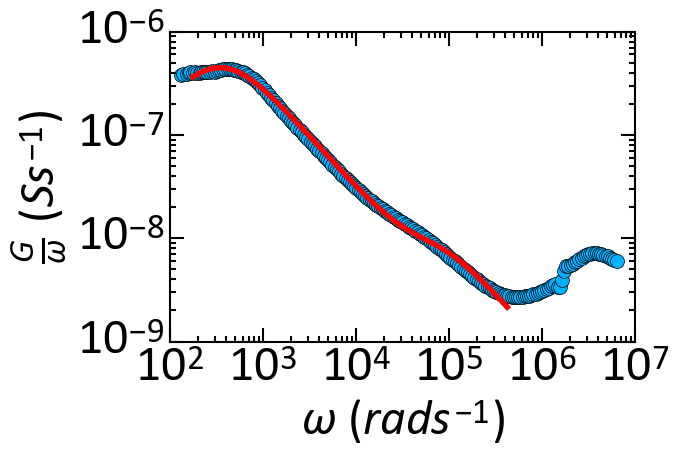

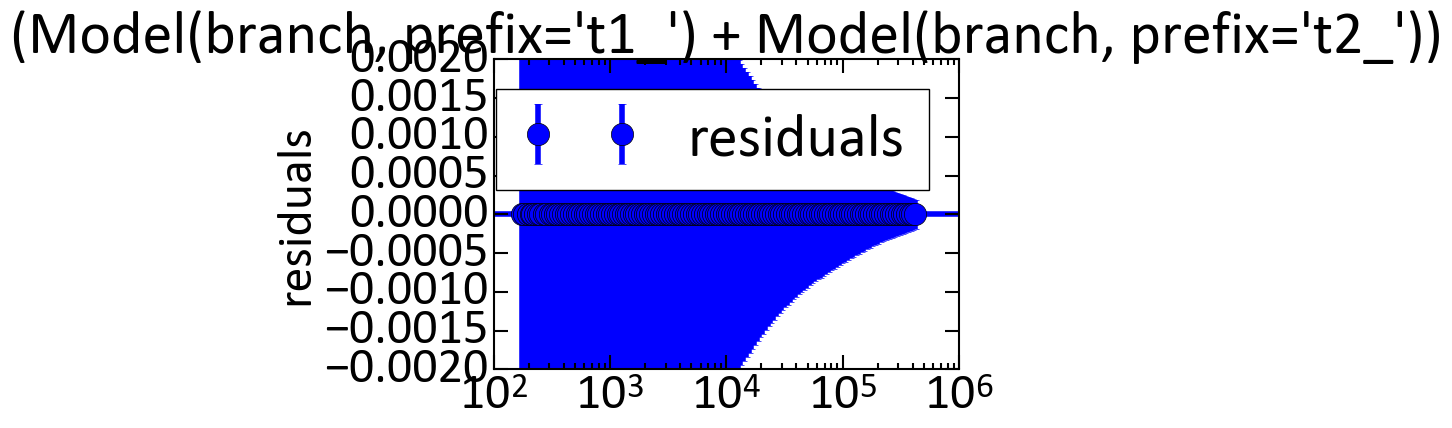

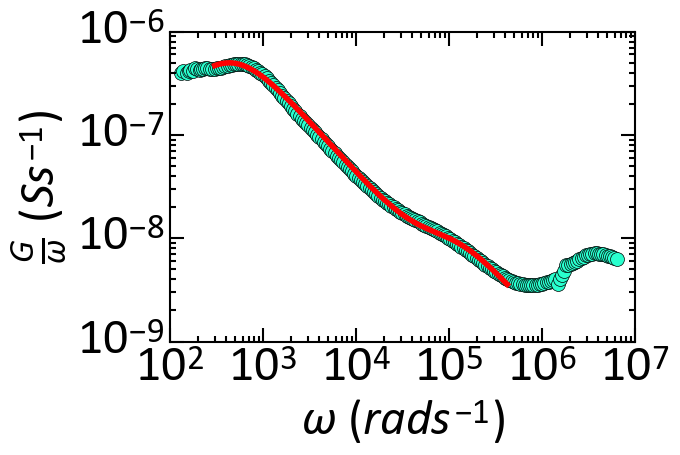

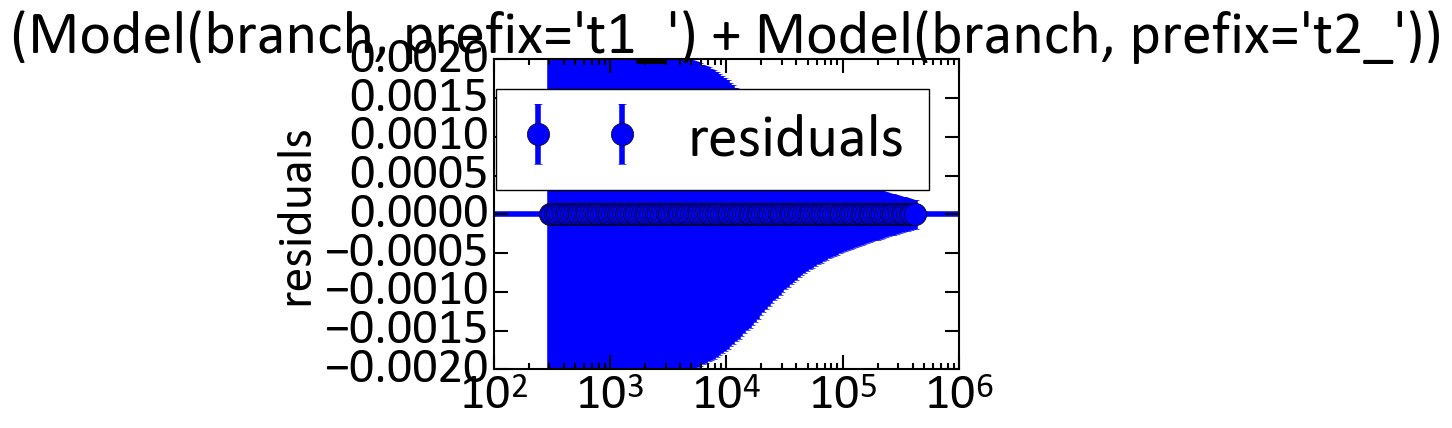

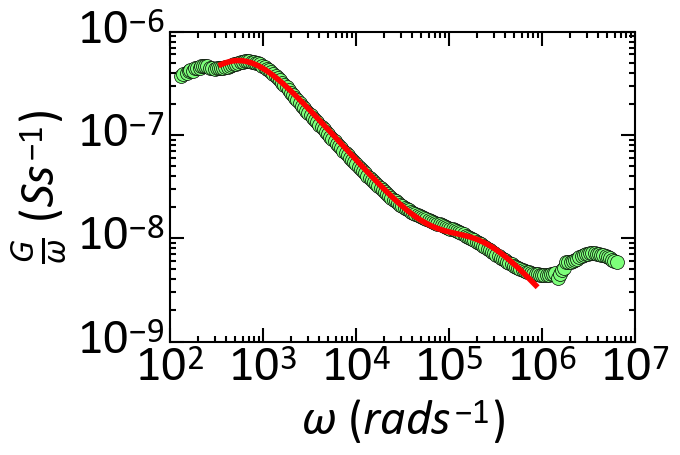

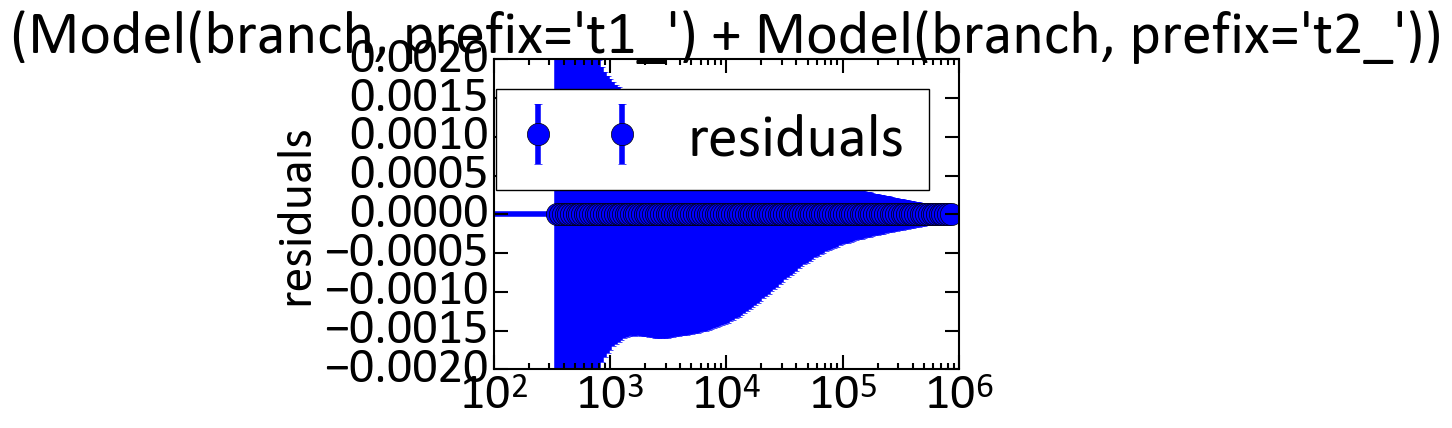

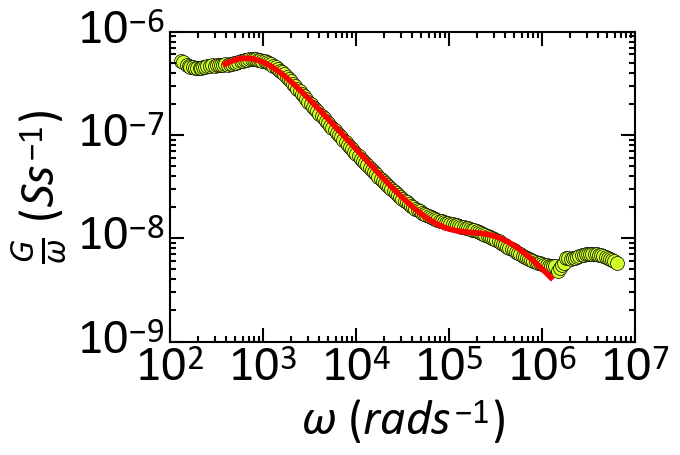

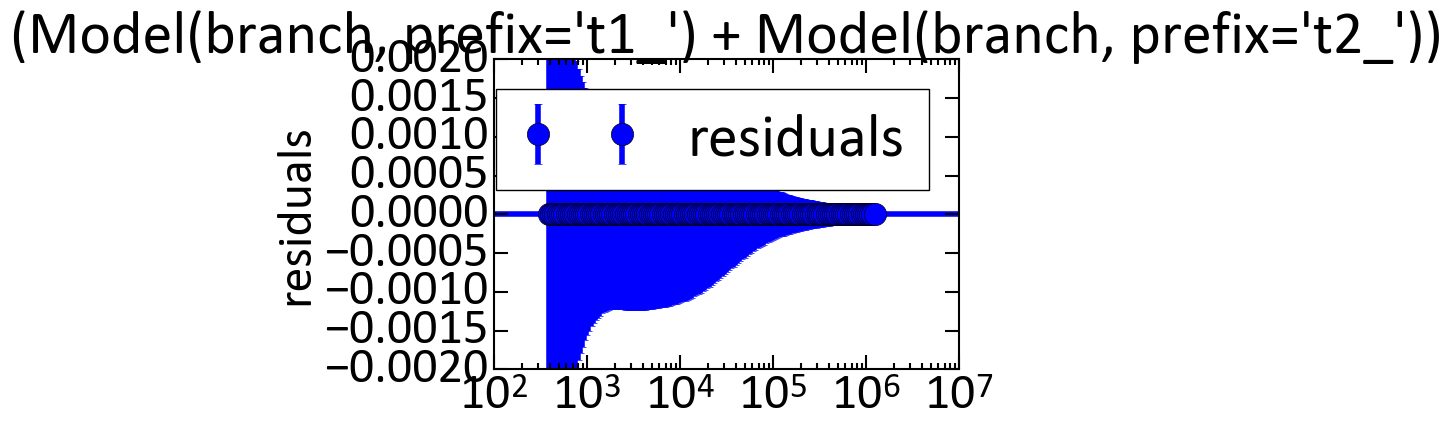

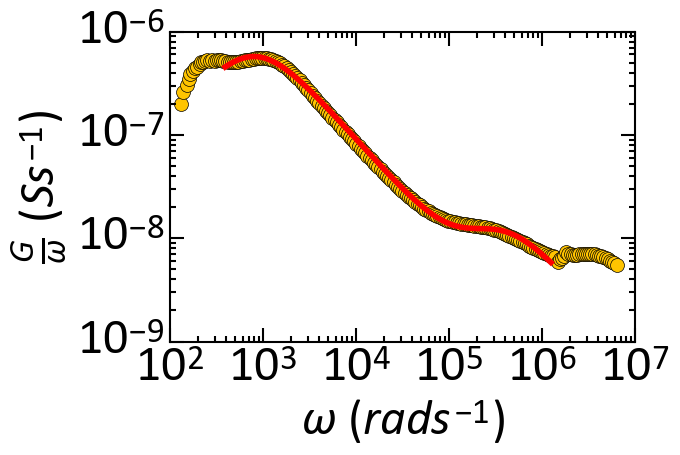

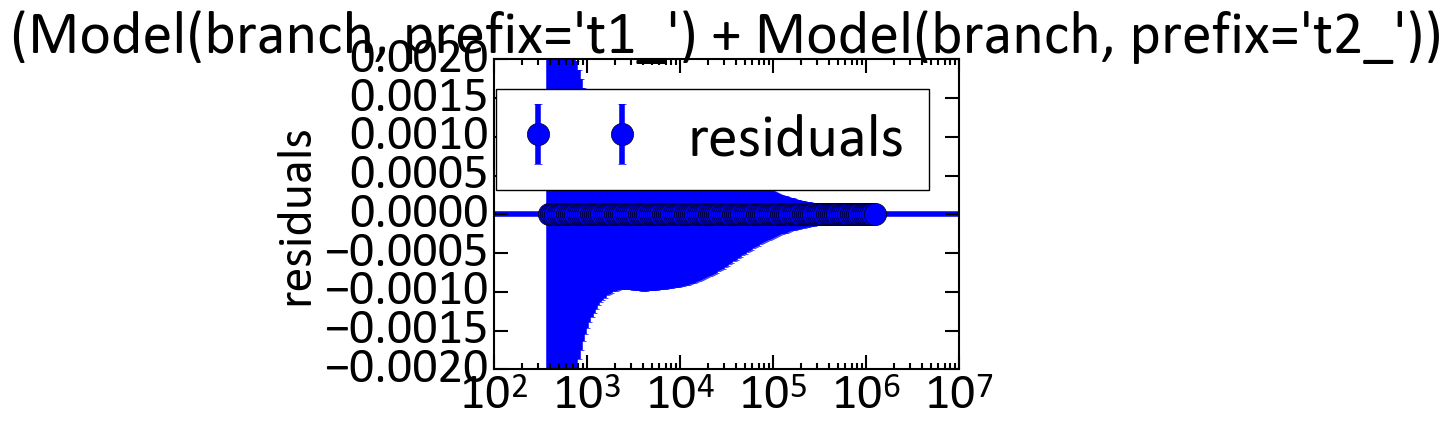

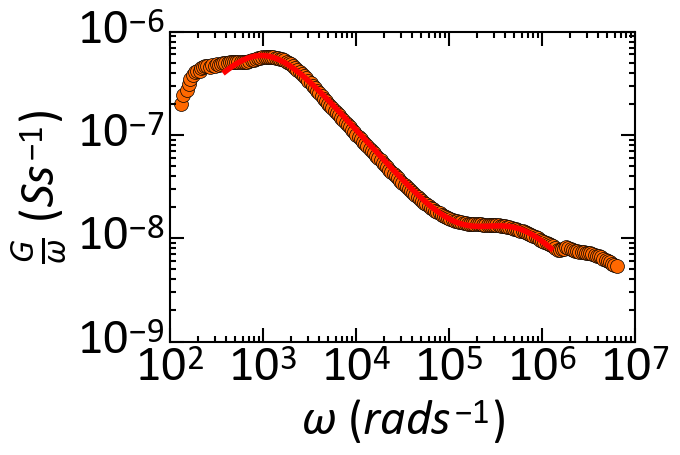

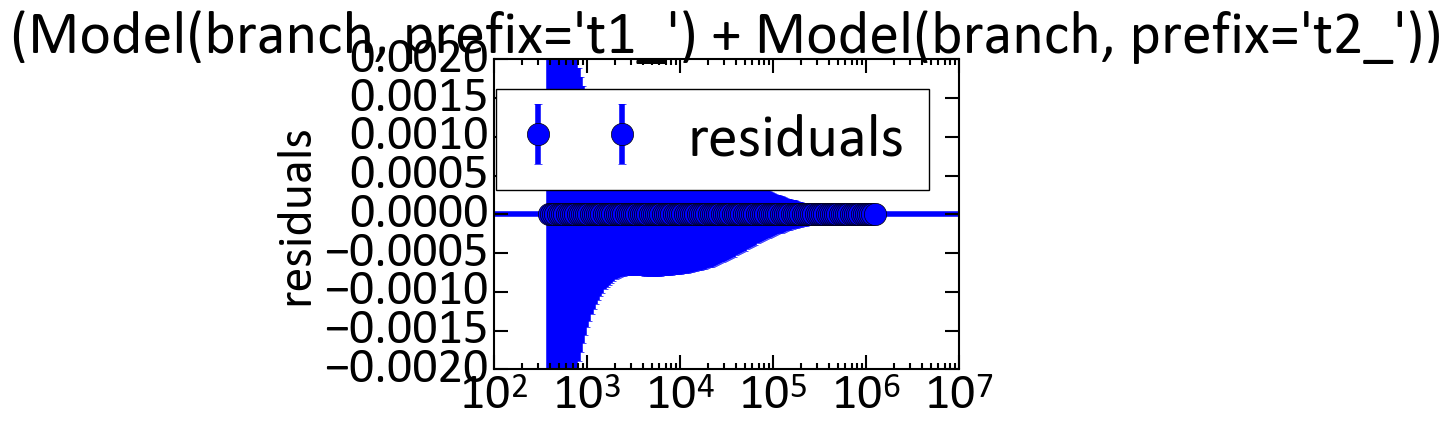

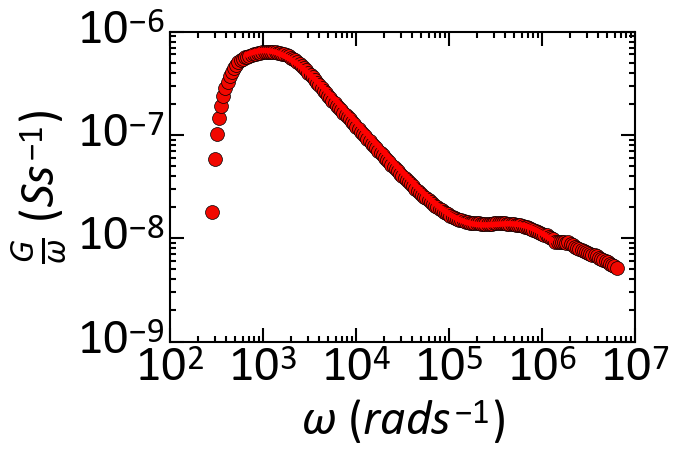

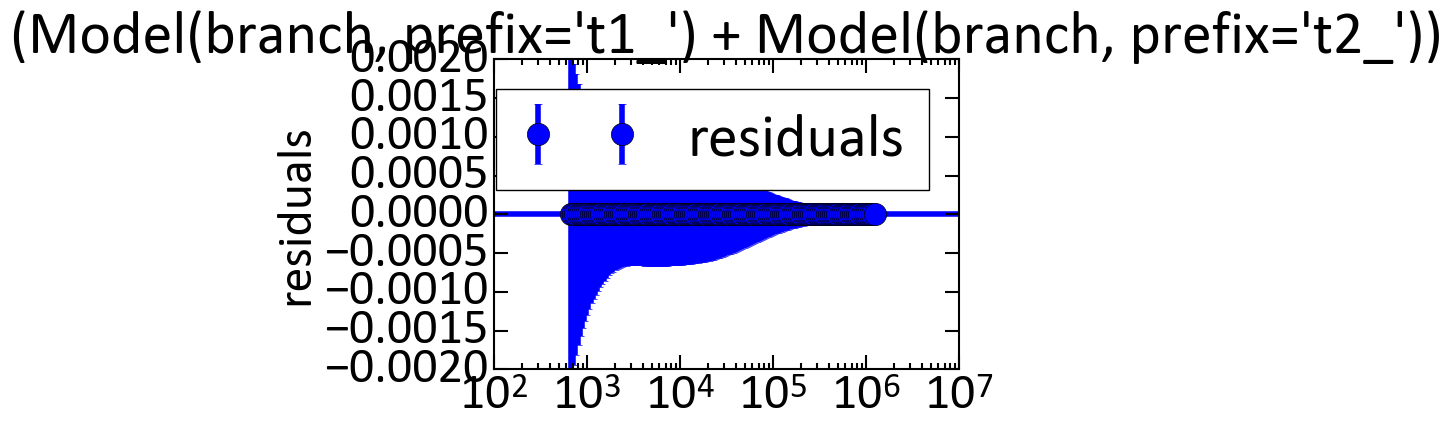

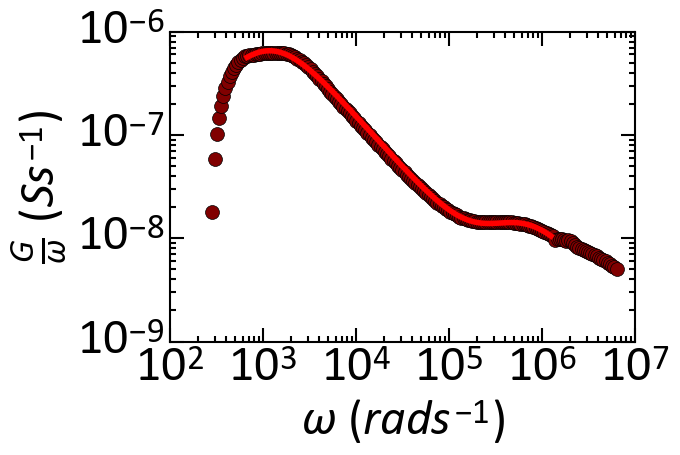

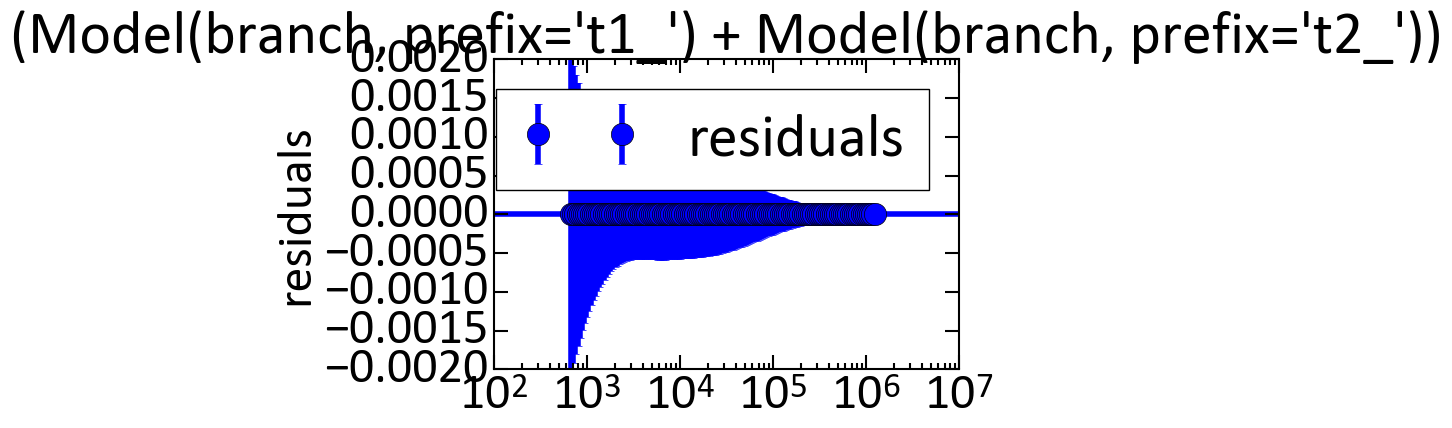

In [9]:
# run the fit in a loop

# define the name for each of the models. note that prefix 't1' is for interface states, 't2' is for deep traps
branch1 = Model(branch,prefix = 't1_')
branch2 = Model(branch,prefix = 't2_')

# define the aggregate moel
gModel = branch1 + branch2

# empty arrays for storing fit parameters
Ct1_fits = []
tau1_fits = []
Ct2_fits = []
tau2_fits =[]

Ct1_err = []
tau1_err =[]
Ct2_err =[]
tau2_err =[]

fitResult_tot = []


# add parameters with guesses
params = lmf.Parameters()  

for t in range(0,tmax):

    params.add('t1_Ct',value = 9e-7, min = 1e-7, max = 2e-6)
    # params.add('t1_tau_t',value = tau1, vary = False, min = 0, max = 1e-1)
    params.add('t1_tau_t',value = tau1[t], min = 0, max = 1e-2)

    params.add('t2_Ct',value = 1e-8, min = 0, max = 1e-7)
    # params.add('t2_tau_t',value = tau2,vary = False, min = 0, max = 1e-3)
    params.add('t2_tau_t', value = tau2[t], min = 0, max = 2e-4)

    # ensure data is run over proper range
    data = (Gw(t)[bound1[t]:bound2[t]])
    weights = 1/(.02*Zmag(t)[bound1[t]:bound2[t]])

    #try the fit
    fit_result = gModel.fit(data, w = w(t)[bound1[t]:bound2[t]],params = params,weights = weights)
    
    Ct1_fits.append(fit_result.params['t1_Ct'].value)
    tau1_fits.append(fit_result.params['t1_tau_t'].value)
    Ct2_fits.append(fit_result.params['t2_Ct'].value)
    tau2_fits.append(fit_result.params['t2_tau_t'].value)
    
    Ct1_err.append(fit_result.params['t1_Ct'].stderr)
    tau1_err.append(fit_result.params['t1_tau_t'].stderr)
    Ct2_err.append(fit_result.params['t2_Ct'].stderr)
    tau2_err.append(fit_result.params['t2_tau_t'].stderr)
    
    fitResult_tot.append(fit_result.best_fit)
    
    print(t)
    print(fit_result.fit_report())


    # G/w with fit
    fig,ax = plt.subplots(1,1)
    ax.plot(w(t),Gw(t),'o',c = tuple(colSet[t]), markersize = 10)
    ax.plot(w(Tt)[bound1[t]:bound2[t]],fit_result.best_fit,color = 'r')
    ax.set_xlabel("$\\omega$ ($rad s^{-1}$)")
    ax.set_ylabel("$\\frac{G}{\omega}$ ($Ss^{-1}$)")
    ax.set_xscale("log") 
    ax.set_yscale("log")
#     figName = '\\G-omega_'+ np.array2string(T[t].astype(int)) + 'K_extended.png'
#     plt.savefig(figDir + figName,dpi = 300,bbox_inches = 'tight')


    fig,ax = plt.subplots(1,1)
    fit_result.plot_residuals(ax=ax)
    ax.set_xscale('log')
    # ax.set_xlim([5e2,1e4])
    ax.set_ylim([-.002,.002])

Now that we've got our fits, let's calculate the $R_{SRH}$ values and plot them, $C_{t}$, and $\tau_{t}$ vs. temperature.

C:\Program Files\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1288: UserWarning: findfont: Font family ['cursive'] not found. Falling back to Bitstream Vera Sans
  (prop.get_family(), self.defaultFamily[fontext]))


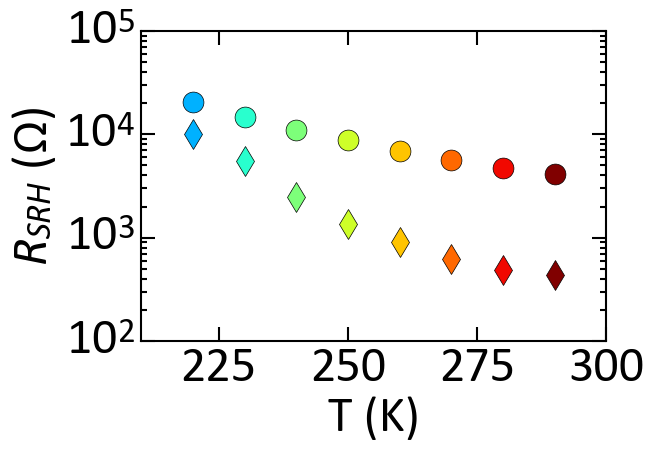

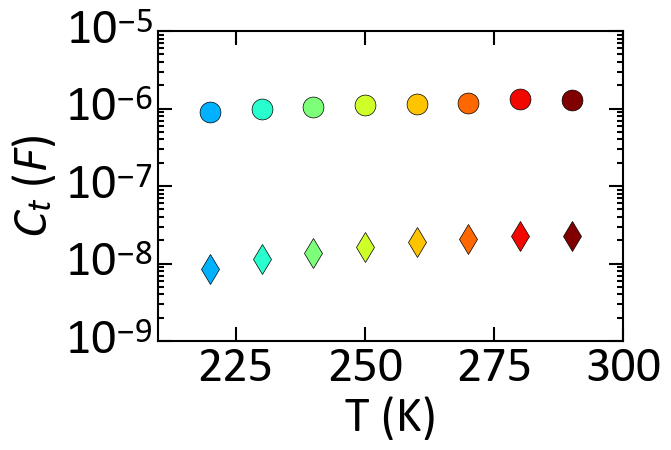

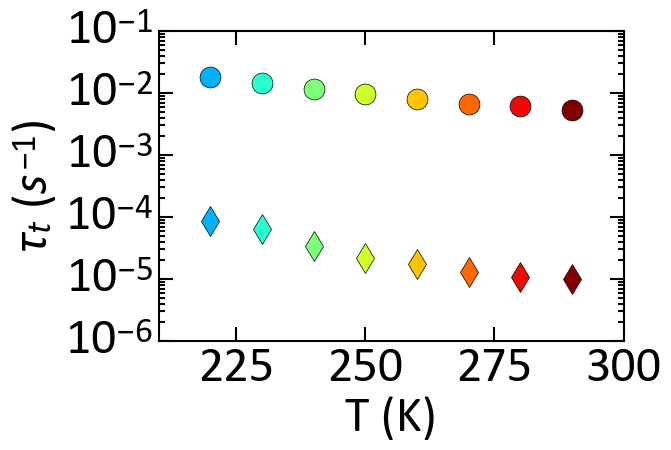

In [10]:
Rt1 = np.zeros(tmax)
Rt2 = np.zeros(tmax)

Rt1_err = np.zeros(tmax)
Rt2_err = np.zeros(tmax)

tau1_val = np.zeros(tmax)
tau2_val = np.zeros(tmax)

tau1_valErr = np.zeros(tmax)
tau2_valErr = np.zeros(tmax)

np.asarray(Ct1_fits)
np.asarray(tau1_fits)
np.asarray(Ct2_fits)
np.asarray(tau2_fits)

np.asarray(Ct1_err)
np.asarray(tau1_err)
np.asarray(Ct2_err)
np.asarray(tau2_err)

np.asarray(fitResult_tot)

for t in range(0,tmax):
    tau1_val[t] = tau1_fits[t]*2*np.pi
    tau2_val[t] = tau2_fits[t]*2*np.pi
      
    tau1_valErr[t] = (tau1_err[t]/tau1_fits[t]) * tau1_val[t]
    tau2_valErr[t] = (tau2_err[t]/tau2_fits[t]) * tau2_val[t]
    
    Rt1[t] = tau1_val[t]/Ct1_fits[t]
    Rt2[t] = tau2_val[t]/Ct2_fits[t]
    
    Rt1_err[t] = np.sqrt( (Ct1_err[t]/Ct1_fits[t])**2 + (tau1_valErr[t]/tau1_val[t])**2 )
    Rt2_err[t] = np.sqrt( (Ct2_err[t]/Ct2_fits[t])**2 + (tau2_valErr[t]/tau2_val[t])**2 )
    

from matplotlib.ticker import MaxNLocator
    
#  Make plots of temperature dependence of parameters   
fig,ax = plt.subplots(1,1)
for t in range(0,tmax):
    ax.errorbar(T[t],Rt1[t],yerr = Rt1_err[t],fmt = 'o',color=tuple(colSet[t]),markersize = 15)
    ax.errorbar(T[t],Rt2[t],yerr = Rt2_err[t],fmt = 'd',color=tuple(colSet[t]),markersize = 15)
ax.set_xlabel("T (K)")
ax.set_ylabel("$R_{SRH}$ ($\Omega$)")
ax.set_yscale('log')
ax.set_xlim([210,300])
ax.xaxis.set_major_locator(MaxNLocator(4))
# figName = '\\Rt_both_extended.png'
# plt.savefig(figDir + figName,dpi = 300,bbox_inches = 'tight')


fig,ax = plt.subplots(1,1)
for t in range(0,tmax):
    ax.errorbar(T[t],Ct1_fits[t],yerr = Ct1_err[t],fmt = 'o',color=tuple(colSet[t]),markersize = 15)
    ax.errorbar(T[t],Ct2_fits[t],yerr = Ct2_err[t],fmt = 'd',color=tuple(colSet[t]),markersize = 15)
ax.set_xlabel("T (K)")
ax.set_ylabel("$C_{t}$ ($F$)")
ax.set_yscale('log')
ax.set_xlim([210,300])
ax.xaxis.set_major_locator(MaxNLocator(4))
# figName = '\\Ct_both_extended.png'
# plt.savefig(figDir + figName,dpi = 300,bbox_inches = 'tight')


fig,ax = plt.subplots(1,1)
for t in range(0,tmax):
    ax.errorbar(T[t],tau1_val[t],yerr = tau1_valErr[t],fmt = 'o',color=tuple(colSet[t]),markersize = 15)
    ax.errorbar(T[t],tau2_val[t],yerr = tau2_valErr[t],fmt = 'd',color=tuple(colSet[t]),markersize = 15)
ax.set_xlabel("T (K)")
ax.set_ylabel("$\\tau_{t}$ ($s^{-1}$)")
ax.set_yscale('log')
ax.set_xlim([210,300])
ax.set_ylim([1e-6,1e-1])
ax.xaxis.set_major_locator(MaxNLocator(4))
# figName = '\\tauT_both_extended.png'
# plt.savefig(figDir + figName,dpi = 300,bbox_inches = 'tight')
    

C:\Program Files\Anaconda3\lib\site-packages\ipykernel\__main__.py:7: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
C:\Program Files\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1288: UserWarning: findfont: Font family ['cursive'] not found. Falling back to Bitstream Vera Sans
  (prop.get_family(), self.defaultFamily[fontext]))


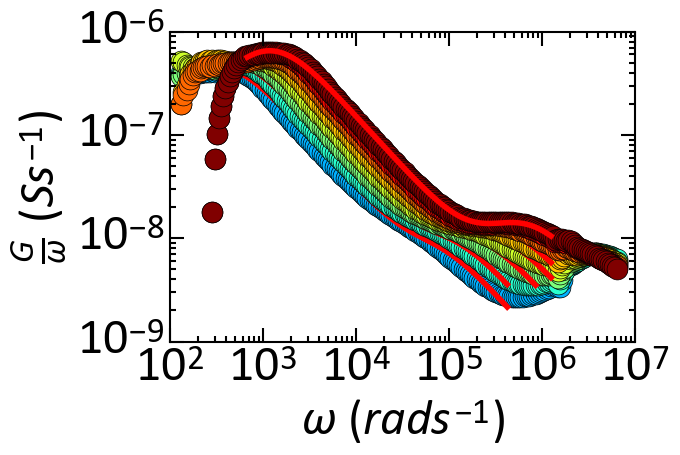

In [11]:
# Make a nice plot of the G-omega plots with the fits

# G/omega plot
fig,ax = plt.subplots(1,1)
for t,c in zip(range(0,tmax),colSet):
    ax.plot(w(t),Gw(t),'o',c = c, markersize = 15)
    ax.plot(w(Tt)[bound1[t]:bound2[t]], fitResult_tot[t],'r')
ax.set_xlabel("$\\omega$ ($rad s^{-1}$)")
ax.set_ylabel("$\\frac{G}{\omega}$ ($Ss^{-1}$)")
ax.set_xscale("log") 
ax.set_yscale("log")
# figName = '\\G-omega_all_fit_extended.png'
# plt.savefig(figDir + figName,dpi = 300,bbox_inches = 'tight')

For completeness, let's calculate the activation energies of these time constants, paying particularly close attention to the high frequency process

0.0869482178598
0.17042010492
0.126571443038
0.258442325683
-0.0287752269479
-0.0771742225323


C:\Program Files\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1288: UserWarning: findfont: Font family ['cursive'] not found. Falling back to Bitstream Vera Sans
  (prop.get_family(), self.defaultFamily[fontext]))


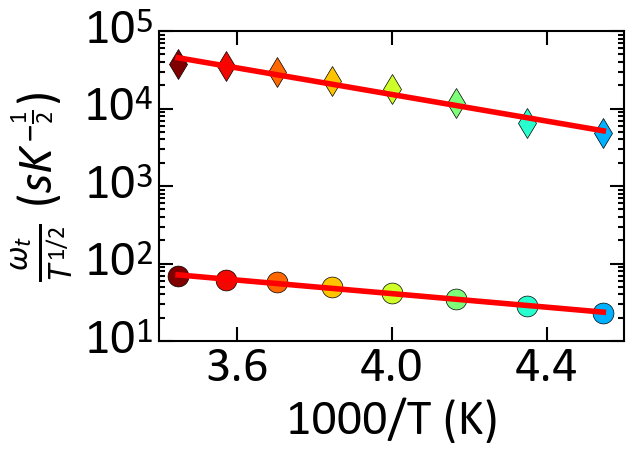

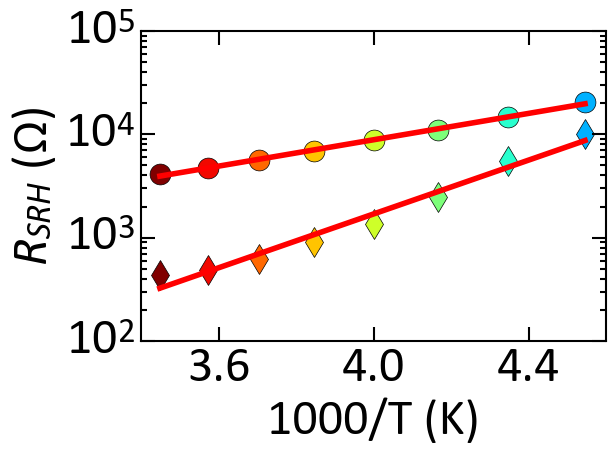

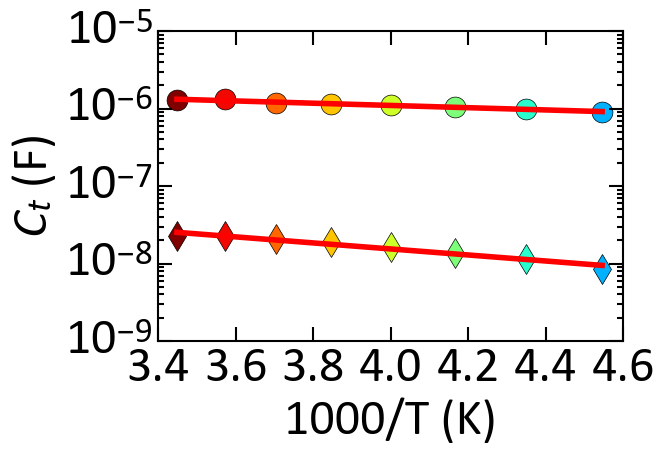

In [12]:
omega_t1 = 1/np.asarray(tau1_fits)
omega_t2 = 1/np.asarray(tau2_fits)


# first run the fit to the first \tau
xt1 = np.vstack( [1e3/T, np.ones(len(T))] ).T
yt1 = np.log(omega_t1/T**(1/2))
mt1,ct1 = np.linalg.lstsq(xt1,yt1)[0]
# print(mt,ct)
Eomega1 = -((kB*mt1)*1e3)
print(Eomega1)
omegaLine1 =  np.exp(mt1*(1e3/T)) * np.exp(ct1)
# print(tauLine)

# off1 = np.where(T ==260)[0][0]

# first run the fit to the second \tau
xt2 = np.vstack( [1e3/T, np.ones(len(T))] ).T
yt2 = np.log(omega_t2/T**(1/2))
mt2,ct2 = np.linalg.lstsq(xt2,yt2)[0]
# print(mt,ct)
Eomega2 = -((kB*mt2)*1e3)
print(Eomega2)
omegaLine2 =  np.exp(mt2*(1e3/T)) * np.exp(ct2)
# print(tauLine)

fig,ax = plt.subplots(1,1)
for t in range(0,tmax):
    ax.plot(1e3/T[t],omega_t1[t]/(T[t]**(1/2)),'o',color=tuple(colSet[t]),markersize = 15)
    ax.plot(1e3/T[t],omega_t2[t]/(T[t]**(1/2)),'d',color=tuple(colSet[t]),markersize = 15)
ax.plot(1e3/T,omegaLine1, 'r')
ax.plot(1e3/T,omegaLine2, 'r')
ax.set_xlabel("1000/T (K)")
ax.set_ylabel("$\\frac{\\omega_t}{T^{1/2}}$ ($sK^{-\\frac{1}{2}}$)")
ax.set_yscale('log')
ax.xaxis.set_major_locator(MaxNLocator(4))
# figName = '\\omegaT_both_extended_fits.png'
# plt.savefig(figDir + figName,dpi = 300,bbox_inches = 'tight')


# try a fit to R_SRH as well
xr1 = np.vstack( [1e3/T, np.ones(len(T))] ).T
yr1 = np.log(Rt1)
mr1,cr1 = np.linalg.lstsq(xr1,yr1)[0]
# print(mt,ct)
Er1 = ((kB*mr1)*1e3)
print(Er1)
rLine1 =  np.exp(mr1*(1e3/T)) * np.exp(cr1)
# print(tauLine)

# first run the fit to the second R_SRH
xr2 = np.vstack( [1e3/T, np.ones(len(T))] ).T
yr2 = np.log(Rt2)
mr2,cr2 = np.linalg.lstsq(xr2,yr2)[0]
# print(mt,ct)
Er2 = ((kB*mr2)*1e3)
print(Er2)
rLine2 =  np.exp(mr2*(1e3/T)) * np.exp(cr2)
# print(tauLine)

fig,ax = plt.subplots(1,1)
for t in range(0,tmax):
    ax.plot(1e3/T[t],Rt1[t],'o',color=tuple(colSet[t]),markersize = 15)
    ax.plot(1e3/T[t],Rt2[t],'d',color=tuple(colSet[t]),markersize = 15)
ax.plot(1e3/T,rLine1, 'r')
ax.plot(1e3/T,rLine2, 'r')
ax.set_xlabel("1000/T (K)")
ax.set_ylabel("$R_{SRH}$ ($\\Omega$)")
ax.set_yscale('log')
ax.xaxis.set_major_locator(MaxNLocator(4))
# figName = '\\Rt_both_extended)fits.png'
# plt.savefig(figDir + figName,dpi = 300,bbox_inches = 'tight')


# do the same for the capacitance
xc1 = np.vstack( [1e3/T, np.ones(len(T))] ).T
yc1 = np.log(Ct1_fits)
mc1,cc1 = np.linalg.lstsq(xc1,yc1)[0]
# print(mt,ct)
Ec1 = ((kB*mc1)*1e3)
print(Ec1)
cLine1 =  np.exp(mc1*(1e3/T)) * np.exp(cc1)
# print(tauLine)

# first run the fit to the second R_SRH
xc2 = np.vstack( [1e3/T, np.ones(len(T))] ).T
yc2 = np.log(Ct2_fits)
mc2,cc2 = np.linalg.lstsq(xc2,yc2)[0]
# print(mt,ct)
Ec2 = ((kB*mc2)*1e3)
print(Ec2)
cLine2 =  np.exp(mc2*(1e3/T)) * np.exp(cc2)
# print(tauLine)

fig,ax = plt.subplots(1,1)
for t in range(0,tmax):
    ax.plot(1e3/T[t],Ct1_fits[t],'o',color=tuple(colSet[t]),markersize = 15)
    ax.plot(1e3/T[t],Ct2_fits[t],'d',color=tuple(colSet[t]),markersize = 15)
ax.plot(1e3/T,cLine1, 'r')
ax.plot(1e3/T,cLine2, 'r')
ax.set_xlabel("1000/T (K)")
ax.set_ylabel("$C_{t}$ (F)")
ax.set_yscale('log')
# ax.xaxis.set_major_locator(MaxNLocator(4))
# figName = '\\Ct_both_extended_fits.png'
# plt.savefig(figDir + figName,dpi = 300,bbox_inches = 'tight')

In [13]:
print(tau1_val)

print(T)

print(tau1_val/T**2)

[ 0.01829297  0.01464393  0.01163897  0.00961268  0.00794218  0.00657472
  0.00614327  0.00537932]
[ 220.  230.  240.  250.  260.  270.  280.  290.]
[  3.77953952e-07   2.76822849e-07   2.02065514e-07   1.53802939e-07
   1.17487881e-07   9.01881446e-08   7.83580426e-08   6.39633553e-08]


In [14]:
test  = np.asarray(tau1_fits)

print(type(tau1_fits))
print(type(test))
print(test)

# tau1_val[t] = tau1_fits[t]*2*np.pi

<class 'list'>
<class 'numpy.ndarray'>
[ 0.00291142  0.00233065  0.0018524   0.00152991  0.00126404  0.0010464
  0.00097773  0.00085615]


In [15]:
omega_t1 = 1/np.asarray(tau1_fits)
omega_t2 = 1/np.asarray(tau2_fits)


print(omega_t1)
print(omega_t2)

[  343.47538256   429.0641828    539.84015533   653.63487677   791.1158813
   955.65885381  1022.77528981  1168.02633682]
[  71602.41717462   99295.61999284  182221.58844288  286435.5906138
  366384.38294011  480958.16809153  584054.16891614  633553.56418306]


C:\Program Files\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1288: UserWarning: findfont: Font family ['cursive'] not found. Falling back to Bitstream Vera Sans
  (prop.get_family(), self.defaultFamily[fontext]))


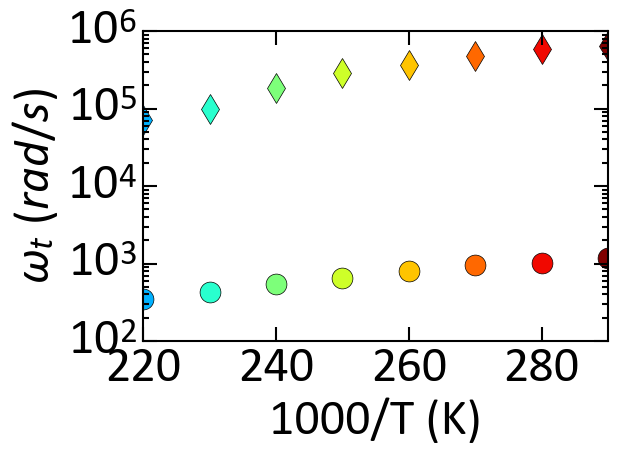

In [19]:
omega_t1 = 1/np.asarray(tau1_fits)
omega_t2 = 1/np.asarray(tau2_fits)

fig,ax = plt.subplots(1,1)
for t in range(0,tmax):
    ax.plot(T[t],omega_t1[t],'o',color=tuple(colSet[t]),markersize = 15)
    ax.plot(T[t],omega_t2[t],'d',color=tuple(colSet[t]),markersize = 15)
# ax.plot(1e3/T,omegaLine1, 'r')
# ax.plot(1e3/T,omegaLine2, 'r')
ax.set_xlabel("1000/T (K)")
ax.set_ylabel("$\\omega_t}$ ($rad/s$)")
ax.set_yscale('log')
ax.xaxis.set_major_locator(MaxNLocator(4))

To try and make sense of this, let's calculate the $E_{\omega}$ value implied by the resonant frequencies. Not that we currently have a super clear physical picture of what each of these should be, but let's just see....

In [23]:
Ew1 = np.zeros(tmax)
Ew2 = np.zeros(tmax)

for t in range(0,tmax):
    Ew1[t] = -kB*T[t]*(np.log(omega_t1[t]/(T[t]**(1/2)))- ct1) 

    Ew2[t] = -kB*T[t]*(np.log(omega_t2[t]/(T[t]**(1/2)))- ct2) 
    
print(Ew1)    
print(Ew2)
    

[ 0.08727914  0.0872773   0.08676236  0.0866966   0.08632696  0.08569001
  0.08766481  0.08791568]
[ 0.17166817  0.17343146  0.16885628  0.16658819  0.16817585  0.1687526
  0.17075552  0.17525948]
